<a href="https://colab.research.google.com/github/ArkanEmre/AI-Based-Retail-Product-Identification/blob/master/ai_based_retail_product_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocessing


In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import csv
import datetime
import itertools
import json
import os
import tarfile
from shutil import copy, copy2, copyfile
from textwrap import wrap

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from google.colab import drive
from keras_preprocessing.image import ImageDataGenerator
from numpy import argmax
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import (AUC, CategoricalAccuracy,
                                      CategoricalCrossentropy,
                                      MeanAbsolutePercentageError, Precision,
                                      Recall)
from tensorflow.keras.preprocessing import image
from tensorflow_addons.metrics import F1Score

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/grozi120.tar.gz", "r")
tar.extractall('/content')

In [4]:
dataset_path = '/content/grozi120'
new_path = '/content/grozi120/processed'

In [5]:
if not os.path.exists(os.path.join(new_path, 'inVitro')):
  os.makedirs(os.path.join(new_path, 'inVitro'))

labels = {}
with open(os.path.join(dataset_path, 'UPC_index.txt'), 'r') as f:
  lines = [line.rstrip() for line in f.readlines()[1:] if line != '\n']
  for i in range(0, len(lines)-2, 3):
    labels[int(lines[i])] = [lines[i+1], lines[i+2]]

dataset = {
  'file_name': [], 
  'label': []
}
for product in os.listdir(os.path.join(dataset_path, 'inVitro'))[:30]:
  for product_file in os.listdir(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG')):
    if product_file == 'Thumbs.db':
      continue
    dataset['file_name'].append(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG', product_file))
    dataset['label'].append(labels[int(product)][1])

df = pd.DataFrame(dataset, columns=['file_name', 'label'])

In [6]:
if not os.path.exists(os.path.join(new_path, 'inSitu')):
    os.makedirs(os.path.join(new_path, 'inSitu'))

evaluation_dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(os.path.join(dataset_path, 'inSitu'))[:30]:
  for product_file in os.listdir(os.path.join(dataset_path, 'inSitu', product, 'video')):
    if product_file == 'Thumbs.db':
      continue
    evaluation_dataset['file_name'].append(os.path.join(dataset_path, 'inSitu', product, 'video', product_file))
    evaluation_dataset['label'].append(labels[int(product)][1])

evaluation_df = pd.DataFrame(evaluation_dataset, columns=['file_name', 'label'])

with open(os.path.join(new_path, 'inSitu', 'evaluation.csv'), mode='w') as dataset_file:
  dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  dataset_writer.writerow(['file_name', 'label'])
  for file_name, label in zip(evaluation_dataset['file_name'], evaluation_dataset['label']):
    split = file_name.split('/')
    dataset_writer.writerow(['{}_{}'.format(split[-3], split[-1]), label])
    copyfile(file_name, os.path.join(new_path, 'inSitu','{}_{}'.format(split[-3], split[-1])))

In [7]:
train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(df['file_name'], df['label'], train_size=0.74, random_state=42, stratify=df['label'])

if not os.path.exists(os.path.join(new_path, 'inVitro', 'train')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'train'))
with open(os.path.join(new_path, 'inVitro', 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-4], split[-1]), label])
        copyfile(file_name, os.path.join(new_path, 'inVitro', 'train','{}_{}'.format(split[-4], split[-1])))

if not os.path.exists(os.path.join(new_path, 'inVitro', 'validation')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'validation'))
with open(os.path.join(new_path, 'inVitro', 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-4], split[-1]), label])
        copyfile(file_name, os.path.join(new_path, 'inVitro', 'validation','{}_{}'.format(split[-4], split[-1])))

In [91]:
! rm -R grozi120/processed/

## Defining data augmentations

In [ ]:
def training_data(file, path):
  global W_SUM
  global H_SUM
  img = cv2.imread(os.path.join(path, file),cv2.IMREAD_COLOR)
  shape = np.array(img).shape
  W_SUM += shape[0]
  H_SUM += shape[1]
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  X.append(np.array(img))

def invert_image(img):
  return (255-img)

Found 122 validated image filenames belonging to 30 classes.
Found 44 validated image filenames belonging to 30 classes.
Found 3448 validated image filenames belonging to 30 classes.


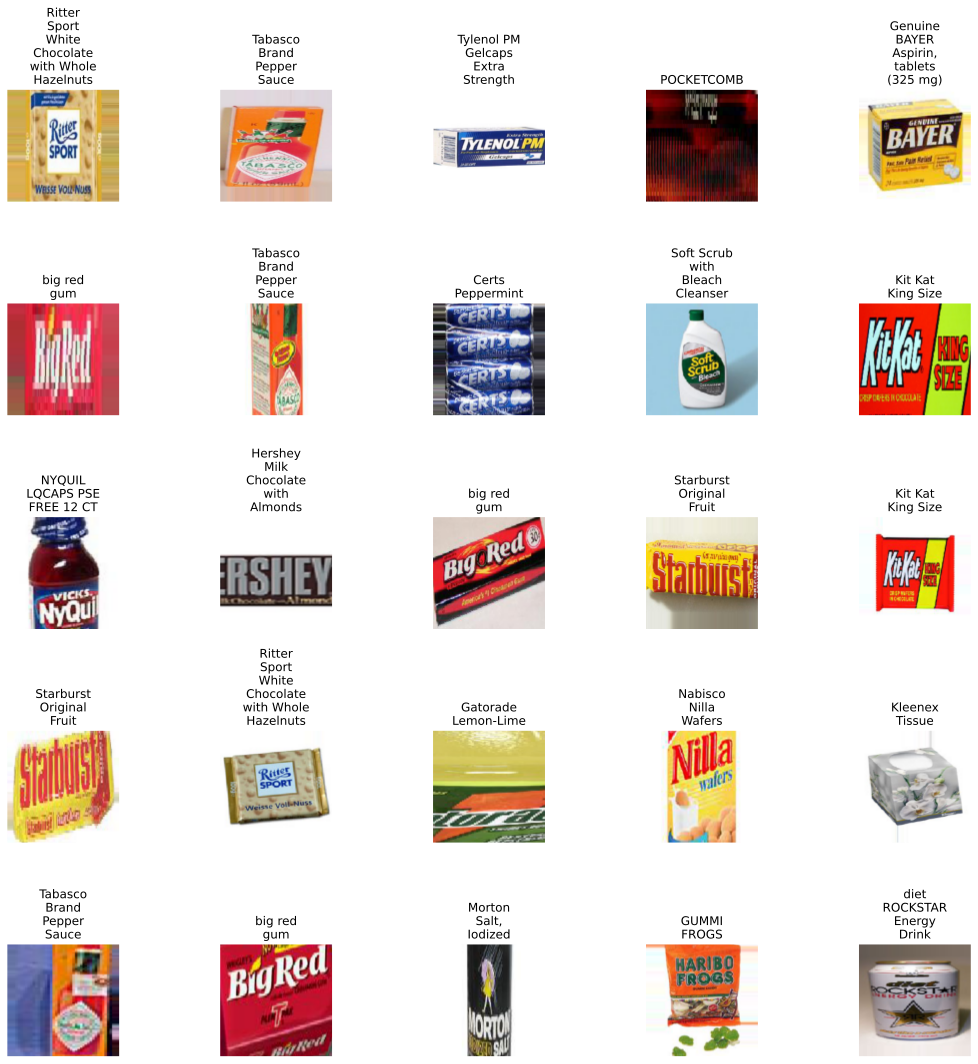

In [21]:
IMG_SIZE = 200
BATCH_SIZE = 128

train_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'train.csv'))
validation_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(new_path, 'inSitu', 'evaluation.csv'))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    featurewise_std_normalization=False, 
    samplewise_center=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=0,  
    zoom_range = 0.5,
    shear_range = 0,
    width_shift_range=0,  
    height_shift_range=0,
    brightness_range=[1,1],
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(new_path, 'inVitro', 'train'),
    x_col="file_name",
    y_col="label",
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=os.path.join(new_path, 'inVitro', 'validation'),
    x_col="file_name",
    y_col="label",
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(
    dataframe=evaluation_df,
    directory=os.path.join(new_path, 'inSitu'),
    x_col="file_name",
    y_col="label",
    class_mode="categorical",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE)

class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

x,y = train_generator.next()
train_generator.reset()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    mydict = evaluation_generator.class_indices
    inverted = list(mydict.keys())[list(mydict.values()).index(argmax(y[num]))]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

In [9]:
evaluation_generator.class_indices

{'Band-Aid flexible fabric': 0,
 "Bull's-Eye BBQ Sauce Original": 1,
 'Certs Peppermint': 2,
 'GUMMI FROGS': 3,
 'Gatorade Lemon-Lime': 4,
 'Genuine BAYER Aspirin, tablets (325 mg)': 5,
 'Glade Potpourri Spray ,Powder Fresh ,9oz.': 6,
 'Hershey Milk Chocolate with Almonds': 7,
 'Honey Nut Cheerios (General Mills)': 8,
 'Jack Links: Extreme Snack Stick': 9,
 'Kit Kat King Size': 10,
 'Kleenex Tissue': 11,
 'Lindt Excellence 70% Cocoa Dark Chocolate': 12,
 'Morton Salt, Iodized': 13,
 'NYQUIL LQCAPS PSE FREE 12 CT': 14,
 'Nabisco Nilla Wafers': 15,
 'POCKETCOMB': 16,
 'Red Bull Sugarfree': 17,
 'Ritter Sport White Chocolate with Whole Hazelnuts': 18,
 'SNYDER PRETZEL OLD TYME': 19,
 'Soft Scrub with Bleach Cleanser': 20,
 'Starburst Original Fruit': 21,
 'Symphony with almonds and toffee chips': 22,
 'Tabasco Brand Pepper Sauce': 23,
 'Tapatio - Salsa Picante': 24,
 'Tostitos Scoops': 25,
 'Tylenol PM Gelcaps Extra Strength': 26,
 'alka Seltzer Plus cold': 27,
 'big red gum': 28,
 'diet 

In [22]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')
                                    
base_model.trainable = False

In [23]:
regularizer = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
global_max_pooling_layer = tf.keras.layers.GlobalMaxPooling2D()
max_pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
dropout_layer = tf.keras.layers.Dropout(0.3)
dense = tf.keras.layers.Dense(2048, activation='relu')
prediction_layer = tf.keras.layers.Dense(30, activation='softmax', activity_regularizer=regularizer)

In [24]:
num_classes = len(train_generator.class_indices)
metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    CategoricalCrossentropy(label_smoothing=0.3),
    F1Score(name='f1score',num_classes=num_classes), 
    MeanAbsolutePercentageError(name='mean_absolute_percentage_error')]

In [25]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = global_average_pooling_layer(x)
x = dense(x)
x = dropout_layer(x)
y = prediction_layer(x)

model = tf.keras.Model(inputs, y)

base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                61470     
Total params: 57,545,982
Trainable params: 3,209,246
Non-trainable params: 54,336,736
__________________________________

In [26]:
num_epochs = 120

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/120
1/1 [==============================] - 4s 4s/step - loss: 3.9299 - categorical_accuracy: 0.0492 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4760 - categorical_crossentropy: 3.9108 - f1score: 0.0215 - mean_absolute_percentage_error: 32189142.0000 - val_loss: 3.4778 - val_categorical_accuracy: 0.0682 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5813 - val_categorical_crossentropy: 3.5462 - val_f1score: 0.0196 - val_mean_absolute_percentage_error: 31924382.0000
Epoch 2/120
1/1 [==============================] - 0s 295ms/step - loss: 3.9378 - categorical_accuracy: 0.0082 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4753 - categorical_crossentropy: 3.9120 - f1score: 0.0013 - mean_absolute_percentage_error: 32414376.0000 - val_loss: 3.4293 - val_categorical_accuracy: 0.0682 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5997 - val_categorical_crossentropy: 3.5057 - val_f1score: 0.0197 - val_mean_absolute_percentage_error:

In [27]:
base_model.trainable = True

base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                61470     
Total params: 57,545,982
Trainable params: 57,485,438
Non-trainable params: 60,544
_____________________________________

In [28]:
fine_tune_epochs = 10

total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator)


Epoch 120/130
1/1 [==============================] - 5s 5s/step - loss: 1.2757 - categorical_accuracy: 0.8253 - precision: 1.0000 - recall: 0.2952 - auc: 0.9873 - categorical_crossentropy: 2.1793 - f1score: 0.7821 - mean_absolute_percentage_error: 20704690.0000 - val_loss: 1.2280 - val_categorical_accuracy: 0.8636 - val_precision: 1.0000 - val_recall: 0.3636 - val_auc: 0.9839 - val_categorical_crossentropy: 2.1483 - val_f1score: 0.7811 - val_mean_absolute_percentage_error: 19881470.0000
Epoch 121/130
1/1 [==============================] - 0s 301ms/step - loss: 1.2538 - categorical_accuracy: 0.8033 - precision: 0.9730 - recall: 0.2951 - auc: 0.9903 - categorical_crossentropy: 2.1818 - f1score: 0.7313 - mean_absolute_percentage_error: 20775672.0000 - val_loss: 1.2152 - val_categorical_accuracy: 0.8636 - val_precision: 1.0000 - val_recall: 0.4091 - val_auc: 0.9841 - val_categorical_crossentropy: 2.1443 - val_f1score: 0.7811 - val_mean_absolute_percentage_error: 19732982.0000
Epoch 122/130

In [18]:
import json

hist_df = pd.DataFrame(history.history) 

# save history to json:  
hist_json_file = '/content/history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
import datetime

#model_path =  '/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_{}.h5'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
#model.save(model_path) 
model.load_weights('/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_19_06_20_13_35_08.h5')

In [29]:
evaluation = model.evaluate(evaluation_generator)

evaluation_df = pd.DataFrame(evaluation) 

# save history to json:  
evaluation_json_file = '/content/evaluation.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_df.to_json(f)

27/27 [==============================] - 13s 482ms/step - loss: 2.6823 - categorical_accuracy: 0.2805 - precision: 0.7551 - recall: 0.0107 - auc: 0.8246 - categorical_crossentropy: 2.9863 - f1score: 0.3090 - mean_absolute_percentage_error: 30016424.0000


In [ ]:
f_scores = model.evaluate(evaluation_generator)[6]

88/88 [==============================] - 41s 464ms/step - loss: 3.1253 - categorical_accuracy: 0.3555 - precision: 0.6282 - recall: 0.2676 - auc: 0.8667 - categorical_crossentropy: 5.1972 - f1score: 0.2995


In [118]:
pos = np.where(f_scores<0.20)
class_names = []
for p in pos[0]:
  class_names.append(class_indices_inverted[p])

class_names

len(class_names)

NameError: ignored

In [119]:
labels

{1: ['310119030486', 'Bausch & Lomb Renu All in One Multi Purpose Solution'],
 2: ['016000126121', 'Chex Mix'],
 3: ['016000166196', "Gardetto's Original Recipe"],
 4: ['016000665903', 'Honey Nut Cheerios (General Mills)'],
 5: ['02209605', 'Wrigleys Extra peppermint gum'],
 6: ['02217206', 'doublemint gum'],
 7: ['02217400', 'big red gum'],
 8: ['323900008748', 'Vicks DayQuil LiquiCaps'],
 9: ['024100122615', 'Cheez-It'],
 10: ['03424102', 'Hershey Milk Chocolate with Almonds'],
 11: ['04002305', 'Twix Cookie Bar'],
 12: ['04010207', 'Snickers'],
 13: ['044600024509', 'CLOROX ULTRA LIQUID REG'],
 14: ['044600038025', 'CLOROX 2 LIQUID 44 OZ'],
 15: ['052000338775', 'Gatorade Lemon-Lime'],
 16: ['077975022337', 'SNYDER PRETZEL OLD TYME'],
 17: ['792554102001', 'POCKETCOMB'],
 18: ['300450481030', 'Motrin IB Ibuprofen Tablets USP'],
 19: ['300810730884', 'Neosporin Original'],
 20: ['078907450372', 'El Sabroso Salsitas Salsa Chips'],
 21: ['00980734', 'Tic Tac Wintergreen'],
 22: ['01254

In [120]:
# from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, file_name='confusion_matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(64,64))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('/content', file_name) + '.svg')

In [116]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float64')/255
    x = np.expand_dims(x, axis=0)
    return x

In [121]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_name"]:
    x = get_image(os.path.join(dataset_path, 'processed', 'inSitu', path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

KeyError: ignored

In [114]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', file_name='confusion_matrix_grozi120')

NameError: ignored